In [21]:
# impoorting libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [22]:
# loading data
data = pd.read_csv("../../cleaned_rwanda_crops_dataset.csv")
# checking data
data.head()
data.info()
data.describe()
data.isnull().sum()
data.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   N                       200 non-null    float64
 1   P                       200 non-null    float64
 2   K                       200 non-null    float64
 3   temperature             200 non-null    float64
 4   humidity                200 non-null    float64
 5   ph                      200 non-null    float64
 6   rainfall                200 non-null    float64
 7   elevation               200 non-null    float64
 8   slope                   200 non-null    float64
 9   aspect                  200 non-null    float64
 10  water_holding_capacity  200 non-null    float64
 11  wind_speed              200 non-null    float64
 12  solar_radiation         200 non-null    float64
 13  ec                      200 non-null    float64
 14  zn                      200 non-null    fl

np.int64(0)

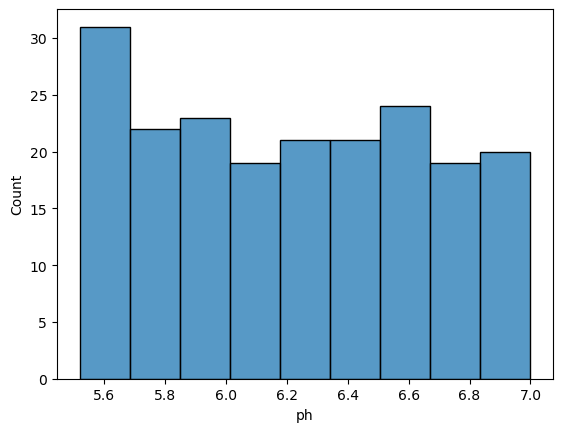

In [ ]:
# visualizing PH distribution
sns.histplot(data['ph'])
plt.show()

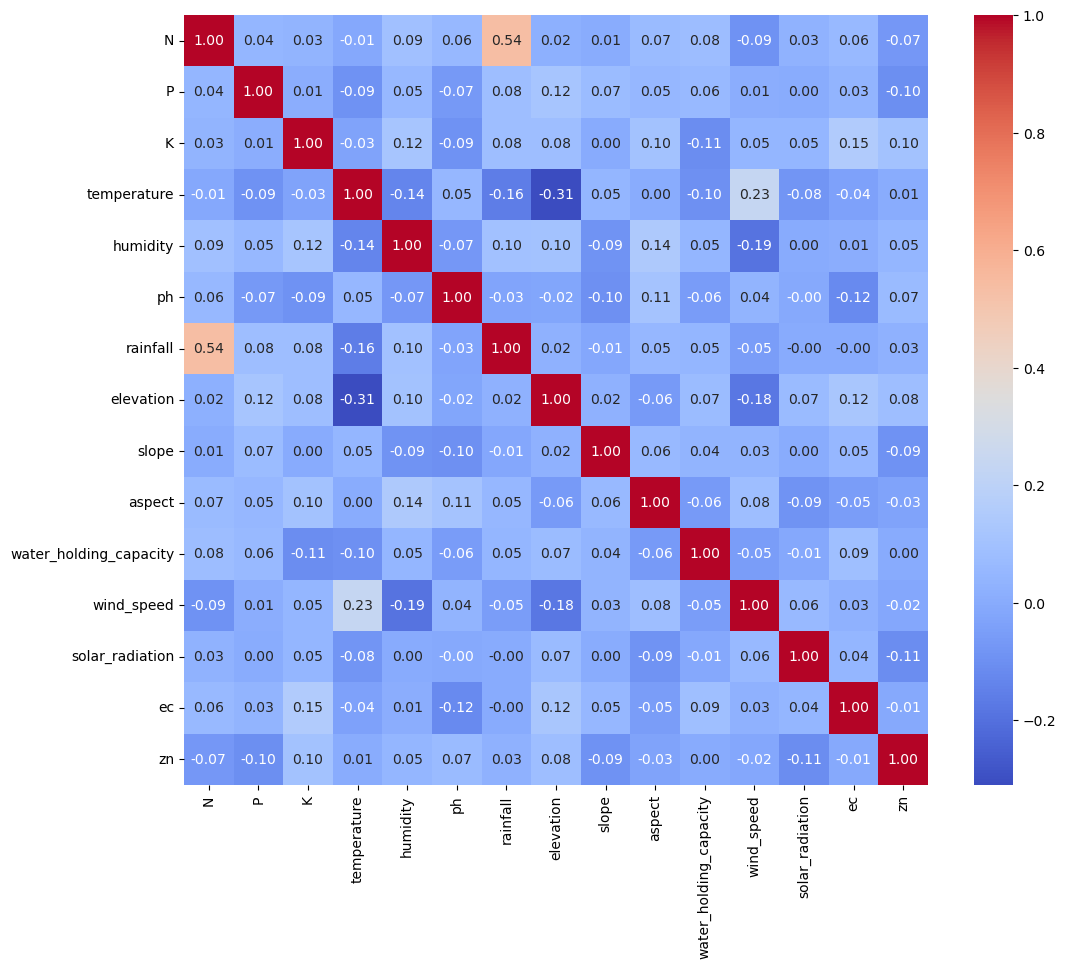

In [ ]:

# correlation heatmap

plt.figure(figsize=(12, 10))
sns.heatmap(data.select_dtypes(include=['number']).corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

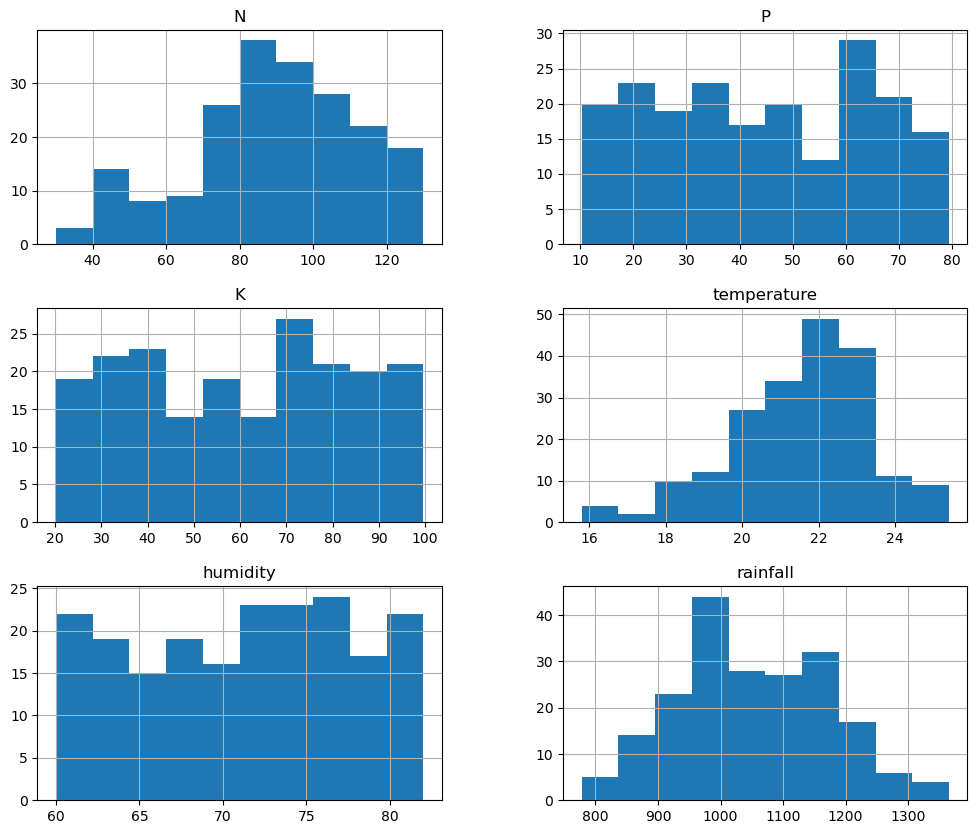

In [ ]:
# variable distribution
data[['N', 'P', 'K', 'temperature', 'humidity', 'rainfall']].hist(figsize=(12, 10))
plt.show()

In [6]:
data = pd.get_dummies(data, columns=["soil_texture"], drop_first=True)

In [7]:
X = data.drop("ph", axis=1)
X = X.drop("label", axis = 1)
y = data["ph"]

In [ ]:
# Scale Numerical Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)
# Split the Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Save the Scaler
joblib.dump(scaler, 'scaler.joblib')

['scaler.joblib']

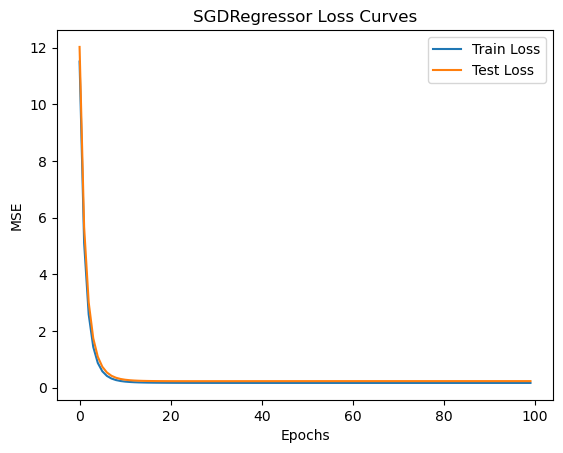

SGD MSE: 0.23098970416803083


In [28]:
sgd_model = SGDRegressor(max_iter=1000, tol=1e-3, random_state=42, warm_start=True)
train_losses = []
test_losses = []
epochs = 100

for epoch in range(epochs):
    sgd_model.partial_fit(X_train, y_train)
    train_predictions = sgd_model.predict(X_train)
    train_loss = mean_squared_error(y_train, train_predictions)
    train_losses.append(train_loss)
    test_predictions = sgd_model.predict(X_test)
    test_loss = mean_squared_error(y_test, test_predictions)
    test_losses.append(test_loss)

plt.plot(range(epochs), train_losses, label='Train Loss')
plt.plot(range(epochs), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('SGDRegressor Loss Curves')
plt.legend()
plt.show()

sgd_predictions = sgd_model.predict(X_test)
sgd_mse = mean_squared_error(y_test, sgd_predictions)
print(f"SGD MSE: {sgd_mse}")

In [29]:
tree_model = DecisionTreeRegressor()
tree_model.fit(X_train, y_train)
tree_predictions = tree_model.predict(X_test)
tree_mse = mean_squared_error(y_test, tree_predictions)
print(f"Tree MSE: {tree_mse}")


Tree MSE: 0.39049249999999996


In [30]:
forest_model = RandomForestRegressor()
forest_model.fit(X_train, y_train)
forest_predictions = forest_model.predict(X_test)
forest_mse = mean_squared_error(y_test, forest_predictions)
print(f"Forest MSE: {forest_mse}")

Forest MSE: 0.23400738125


In [31]:
best_model = None
best_mse = None
if sgd_mse < tree_mse and sgd_mse < forest_mse:
    best_model = sgd_model
    best_mse = sgd_mse
elif tree_mse < sgd_mse and tree_mse < forest_mse:
    best_model = tree_model
    best_mse = tree_mse
else:
    best_model = forest_model
    best_mse = forest_mse

joblib.dump(best_model, "best_ph_model.joblib")
print(f"Best Model MSE: {best_mse}")

Best Model MSE: 0.23098970416803083


/home/chris/miniconda3/envs/soil_ph_env/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SGDRegressor was fitted with feature names
  warnings.warn(


Example prediction: 6.501446436496081


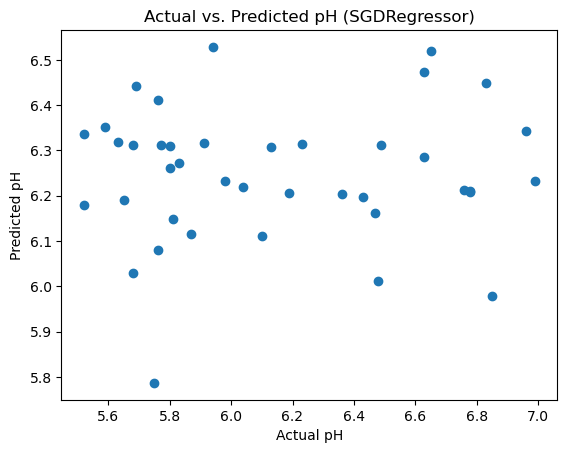

Index(['N', 'P', 'K', 'temperature', 'humidity', 'rainfall', 'elevation',
       'slope', 'aspect', 'water_holding_capacity', 'wind_speed',
       'solar_radiation', 'ec', 'zn', 'soil_texture_Loam',
       'soil_texture_Sandy', 'soil_texture_Sandy Clay',
       'soil_texture_Sandy Loam'],
      dtype='object')
['N' 'P' 'K' 'temperature' 'humidity' 'rainfall' 'elevation' 'slope'
 'aspect' 'water_holding_capacity' 'wind_speed' 'solar_radiation' 'ec'
 'zn' 'soil_texture_Loam' 'soil_texture_Sandy' 'soil_texture_Sandy Clay'
 'soil_texture_Sandy Loam']


In [35]:
import joblib
import pandas as pd  # Import pandas

def predict_ph(input_data):
    model = joblib.load("best_ph_model.joblib")
    scaler = joblib.load('scaler.joblib')
    scaled_input = scaler.transform(input_data)  # Scale the DataFrame directly
    prediction = model.predict(scaled_input)
    return prediction[0]

#prediction code.
example_input = X_test.iloc[[0]] #pass as a dataframe.
example_prediction = predict_ph(example_input)
print(f"Example prediction: {example_prediction}")

sgd_predictions = sgd_model.predict(X_test)

plt.scatter(y_test, sgd_predictions)
plt.xlabel("Actual pH")
plt.ylabel("Predicted pH")
plt.title("Actual vs. Predicted pH (SGDRegressor)")
plt.show()
print(X_test.columns)
print(sgd_model.feature_names_in_)